# Detecting Anomalies in Energy Consumption over Time

In this notebook, I look at a single household's electric load profile between January 2000 and June 2024 to try and identifiy anomalies. Anomalies can include sudden spikes in consumption, sudden drops in consumption, or significant deviations from past patterns. Anomaly detection can help homeowners and utilities discover problems and inefficiencies, such as equipment failiures.

## Part 1: Visualize the Data
Data is stored in a dataframe publicly available at PG&E's website (https://www.pge.com/assets/rates/tariffs/energy_use_prices.shtml). It contains the average hourly residential load profile between January 1, 2000 and June 11, 2024. The consumption values are in kW.

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('e1_dynamic_2001.csv')
df.head()

Profile    Date  1:00 AM  2:00 AM  3:00 AM  4:00 AM  5:00 AM  6:00 AM  \
0      E1  1/1/00  0.74620  0.62720  0.52165  0.47795  0.46230  0.51540   
1      E1  1/2/00  0.59680  0.52495  0.49045  0.47535  0.48250  0.52535   
2      E1  1/3/00  0.54905  0.48845   0.4656  0.46175  0.47220  0.58245   
3      E1  1/4/00  0.53230  0.46455  0.44595  0.45535  0.47085  0.57700   
4      E1  1/5/00  0.52660  0.47115   0.4544  0.43370  0.45400  0.56540   

   7:00 AM  8:00 AM  ...  3:00 PM  4:00 PM  5:00 PM  6:00 PM  7:00 PM  \
0   0.5489  0.59705  ...  0.85130  0.81435  0.89675  1.07755   1.1530   
1   0.5625  0.64935  ...  0.73315  0.78610  0.87315  1.11845   1.1836   
2   0.7160  0.80320  ...  0.62335  0.66355  0.76320  1.09490   1.2284   
3   0.7772  0.86800  ...  0.60235  0.64020  0.75495  1.05280   1.1710   
4   0.7247  0.81190  ...  0.57055  0.59625  0.70390  1.01990   1.1770   

   8:00 PM  9:00 PM  10:00 PM  11:00 PM  12:00 AM  
0  1.12460  1.05845   0.95010   0.82915   0.68815  
1  1.14240  1.10440   1.02595   0.87215   0.67655  
2  1.17955  1.12770   1.00790   0.81315   0.63210  
3  1.17660  1.10445   0.97955   0.79850   0.63155  
4  1.17845  1.06935   0.96955   0.80610   0.63110  

[5 rows x 26 columns]

### Reshape dataframe to have two columns: timestamp and consumption

In [4]:
df = df.drop(columns=['Profile']) # don't need this column
df.set_index('Date', inplace=True)
df = df.stack().reset_index() # reshape so that all the values are in one column
df.columns = ['Date', 'Time', 'Consumption']
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='mixed') # combine date and time into single 'Timestamp' column
df.set_index('Timestamp', inplace=True)
df = df.drop(columns=['Date', 'Time'])
print(len(df))
df.head() 

180672


Consumption
Timestamp                      
2000-01-01 01:00:00      0.7462
2000-01-01 02:00:00      0.6272
2000-01-01 03:00:00     0.52165
2000-01-01 04:00:00     0.47795
2000-01-01 05:00:00      0.4623

### Clean data
The energy consumption column has some missing values denoted with '.' that I'm replacing with null values.

In [5]:
df['Consumption'] = pd.to_numeric(df['Consumption'], errors='coerce')
df[df['Consumption'].isnull()]

Consumption
Timestamp                       
2000-04-02 03:00:00          NaN
2001-04-01 03:00:00          NaN
2002-04-07 03:00:00          NaN
2003-04-06 03:00:00          NaN
2004-04-04 03:00:00          NaN

In [6]:
# Linearly interpolate null values
df['Consumption'] = df['Consumption'].interpolate(method='linear')
df[df['Consumption'].isnull()] # no more null values

Empty DataFrame
Columns: [Consumption]
Index: []

### Plot overall energy consumption over time
There is a large gap of time in which no data was collected, between March 1, 2012 and January 2, 2016. I will indicate this gap on the plot.

In [7]:
import matplotlib.pyplot as plt

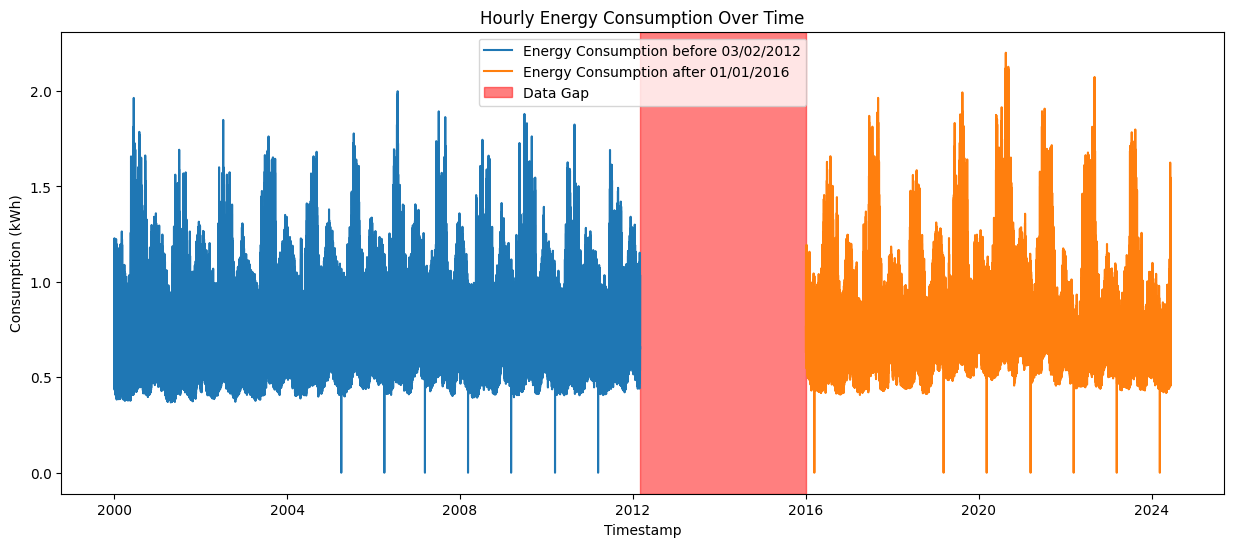

In [8]:
# Segment the data before and after the gap
pre_df = df[df.index < '2012-03-02']
post_df = df[df.index > '2016-01-01']

plt.figure(figsize=(15, 6))

plt.plot(pre_df['Consumption'], label='Energy Consumption before 03/02/2012')
plt.plot(post_df['Consumption'], label='Energy Consumption after 01/01/2016')
plt.axvspan('2012-03-02', '2016-01-01', color='red', alpha=0.5, label='Data Gap') # highlight gap in red
plt.xlabel('Timestamp')
plt.ylabel('Consumption (kWh)')
plt.title('Hourly Energy Consumption Over Time')
plt.legend()
plt.show()

Already, from this overall graph, I can see that there are strange periodic drops in consumption from about 2005 onward. Also, the highest peak seams to be in 2020, which is probably due to people being in their homes more due to the Covid-19 pandemic. 

### Plot consumption over time by year
For each year, I'm also plotting the rolling average energy consumption within a 24-hour window smoothen the curve.

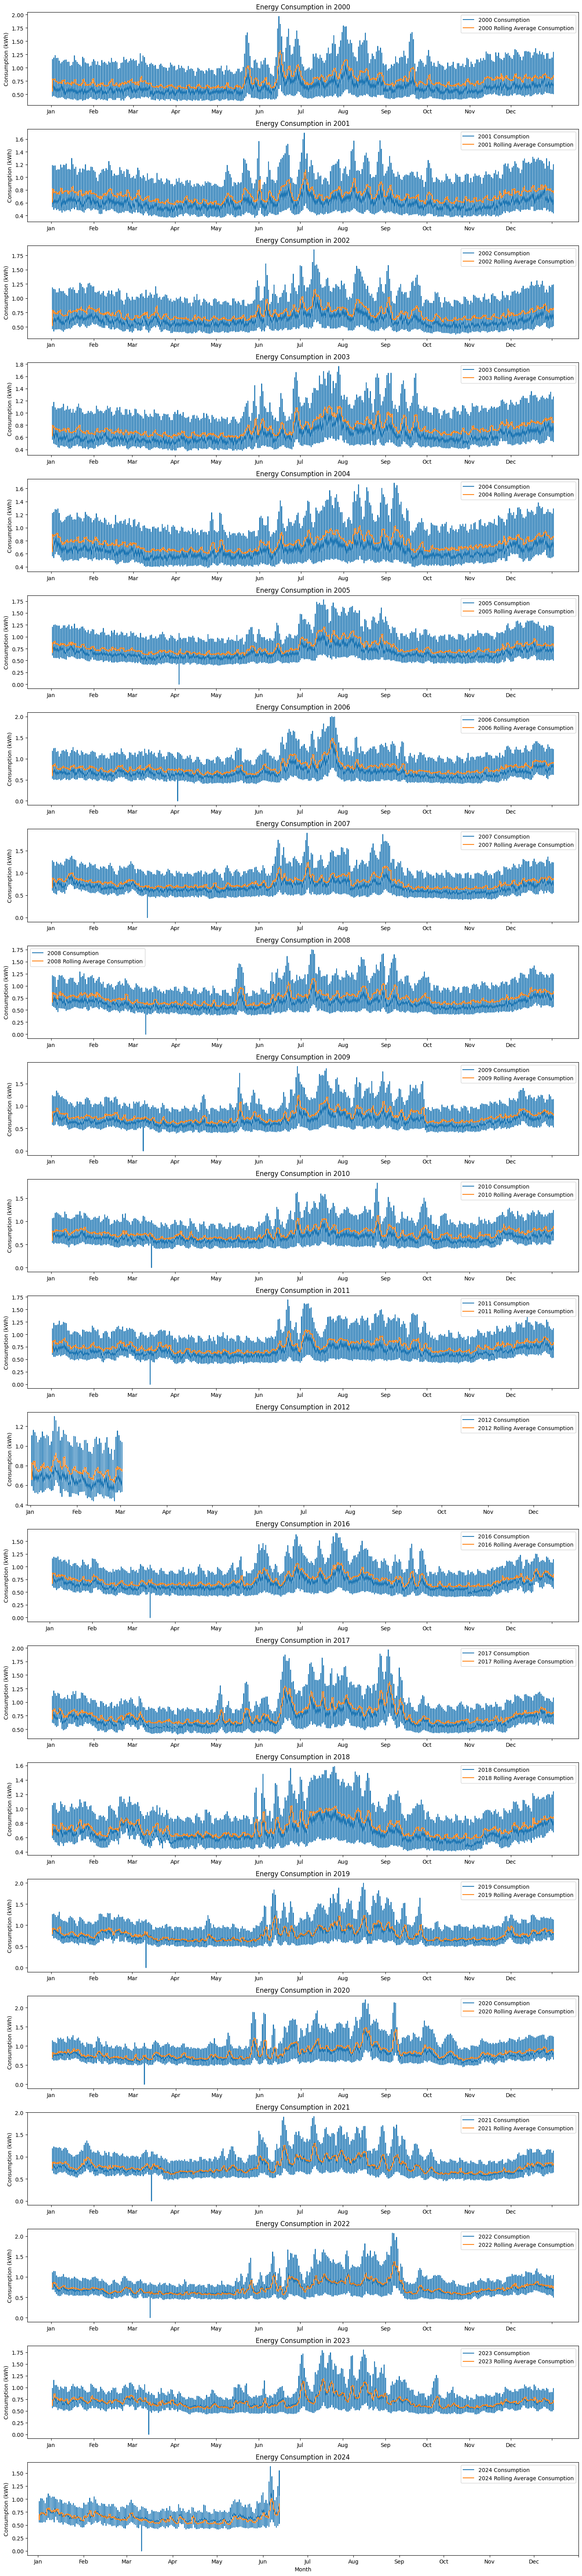

In [9]:
years = df.index.year.unique()
num_years = len(years)
fig, axes = plt.subplots(num_years, 1, figsize=(15, num_years*3))

for i, year in enumerate(years):
    tick_positions = []
    if year % 4 == 0: # leap year
        tick_positions = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335, 365]
    else:
        tick_positions = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 364]
    tick_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']

    df_year = df[df.index.year == year].copy()
    df_year['Rolling Mean'] = df_year['Consumption'].rolling(window=24, min_periods=1).mean()
    ax = axes[i]
    ax.plot(df_year.index.day_of_year, df_year['Consumption'], label=f'{year} Consumption')
    ax.plot(df_year.index.day_of_year, df_year['Rolling Mean'], label=f'{year} Rolling Average Consumption')
    ax.set_title(f'Energy Consumption in {year}')
    ax.set_ylabel('Consumption (kWh)')
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.legend()

plt.xlabel('Month')
plt.tight_layout()
plt.show()

The yearly drops I mentioned earlier can be seen more clearly in these graphs. I see that they occur in many years around March or April. Energy usage increases in the summer, whcih makes sense because people are using more air conditioning. 

### Plot average hourly consumption

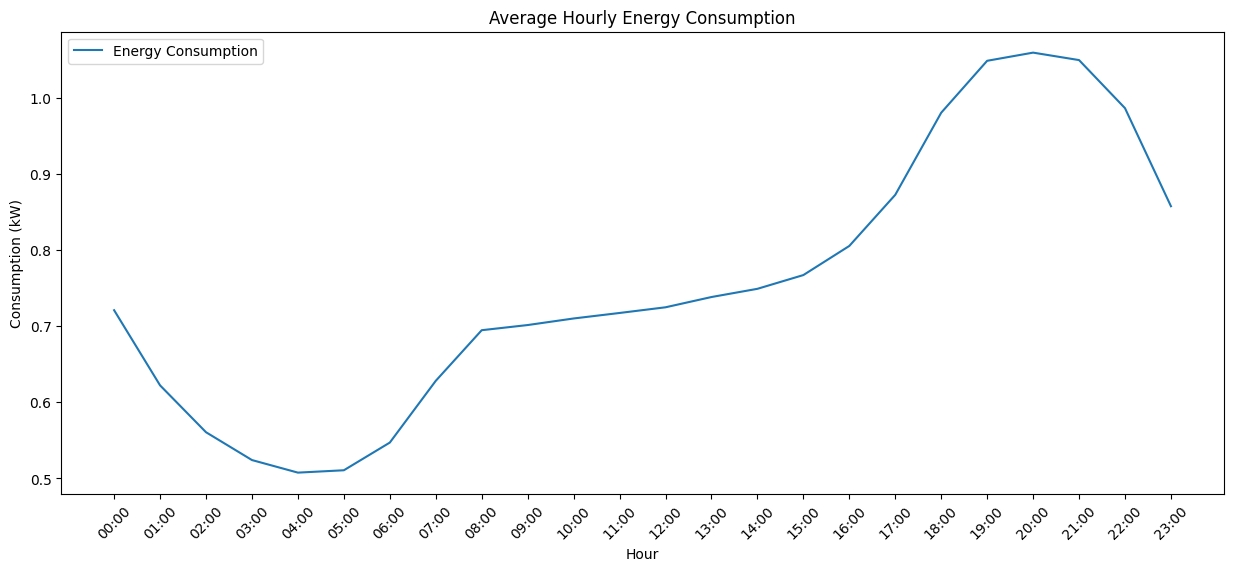

In [10]:
hourly_df = df.copy()
hourly_df['Hour'] = hourly_df.index.hour
hourly_consumption = hourly_df.groupby('Hour')['Consumption'].mean()

x_labels = [
    '00:00',
    '01:00',
    '02:00',
    '03:00',
    '04:00',
    '05:00',
    '06:00',
    '07:00',
    '08:00',
    '09:00',
    '10:00',
    '11:00',
    '12:00',
    '13:00',
    '14:00',
    '15:00',
    '16:00',
    '17:00',
    '18:00',
    '19:00',
    '20:00',
    '21:00',
    '22:00',
    '23:00'
]

plt.figure(figsize=(15, 6))
plt.plot(hourly_consumption.index, hourly_consumption.values, label='Energy Consumption')
plt.xlabel('Hour')
plt.xticks(ticks=np.arange(0, 24), labels=x_labels, rotation=45)
plt.ylabel('Consumption (kW)')
plt.title('Average Hourly Energy Consumption')
plt.legend()
plt.show()

### Plot average hourly consumption by year

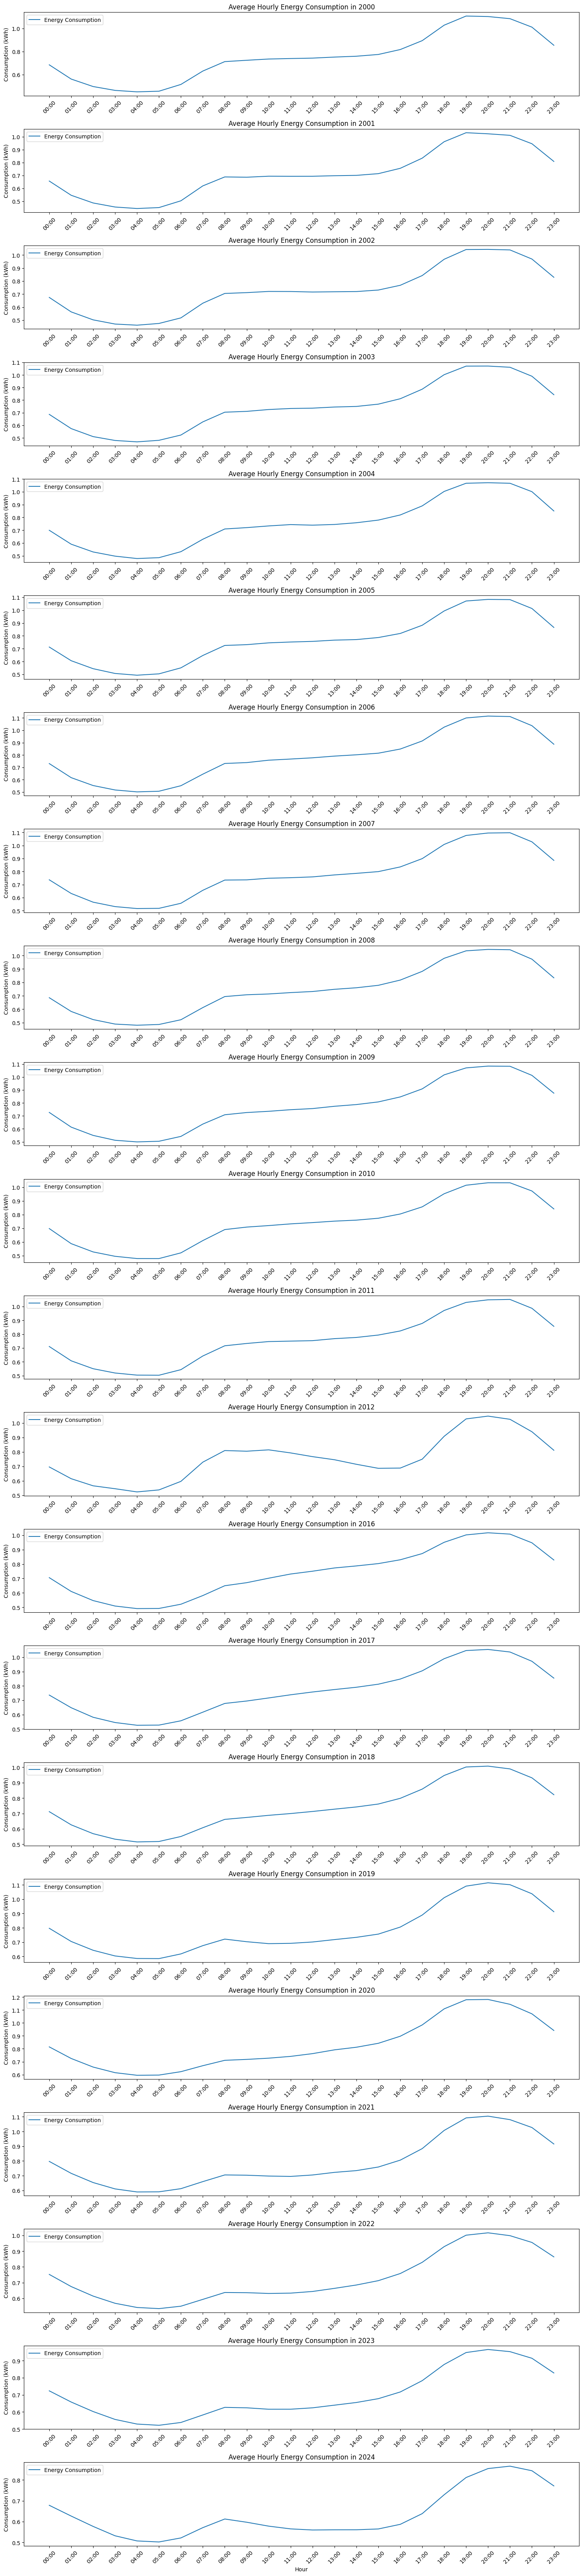

In [11]:
fig, axes = plt.subplots(num_years, 1, figsize=(15, num_years*3))

for i, year in enumerate(years):
    df_year = df[df.index.year == year].copy()
    df_year['Hour'] = df_year.index.hour
    hourly_consumption = df_year.groupby('Hour')['Consumption'].mean()
    
    ax = axes[i]
    ax.plot(hourly_consumption.index, hourly_consumption.values, label='Energy Consumption')
    ax.set_title(f'Average Hourly Energy Consumption in {year}')
    ax.set_ylabel('Consumption (kWh)')
    ax.set_xticks(np.arange(0, 24))
    ax.set_xticklabels(x_labels, rotation=45)
    ax.legend()

plt.xlabel('Hour')
plt.tight_layout()
plt.show()

The hourly curve looks roughly the same shape in most years, with the most noticable deviations in 2012.

### Plot seasonal decomposition
Seasonal decomposition splits time series data into trend, seasonal, and residual components that are added together to form the original data. The trend component is a smoothened curve that shows long term tendencies in the data. The seasonal component shows periodic patterns, and the residual component is the error between the trend + seasonal components and the original curve. Deviations in the residual component highlight anomalies in the data.

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

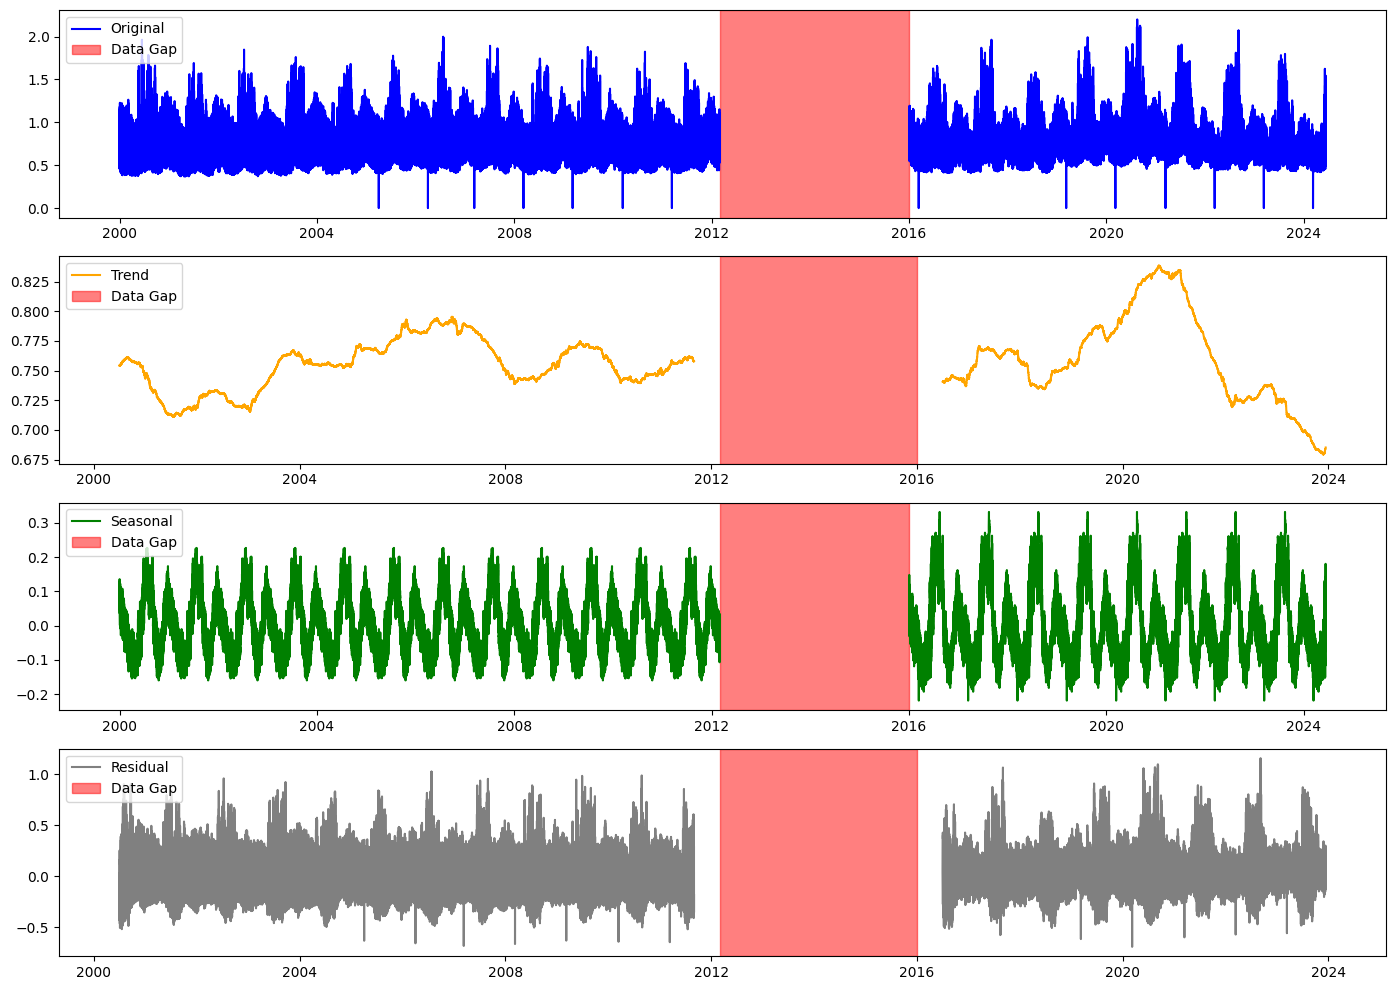

In [13]:
# Perform seasonal decomposition
pre_decomposition = seasonal_decompose(pre_df['Consumption'], model='additive', period=8766) # 8766 is the average number of hours per year, taking leap years into account
post_decomposition = seasonal_decompose(post_df['Consumption'], model='additive', period=8766)

# Extract the components
pre_trend = pre_decomposition.trend
pre_seasonal = pre_decomposition.seasonal
pre_residual = pre_decomposition.resid
post_trend = post_decomposition.trend
post_seasonal = post_decomposition.seasonal
post_residual = post_decomposition.resid

# Plot the decomposition
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(pre_df['Consumption'], label='Original', color='blue')
plt.plot(post_df['Consumption'], color='blue')
plt.axvspan('2012-03-02', '2016-01-01', color='red', alpha=0.5, label='Data Gap') # highlight gap in red
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(pre_trend, label='Trend', color='orange')
plt.plot(post_trend, color='orange')
plt.axvspan('2012-03-02', '2016-01-01', color='red', alpha=0.5, label='Data Gap')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(pre_seasonal, label='Seasonal', color='green')
plt.plot(post_seasonal, color='green')
plt.axvspan('2012-03-02', '2016-01-01', color='red', alpha=0.5, label='Data Gap')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(pre_residual, label='Residual', color='gray')
plt.plot(post_residual, color='gray')
plt.axvspan('2012-03-02', '2016-01-01', color='red', alpha=0.5, label='Data Gap')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


The trend component indicates relatively stable energy consumption before 2012 and a distinct rise in consumption around 2020, followed by a decrease in consumption. As I mentioned earlier, this is most likely due to the Covid-19 pandemic. Similarly, the magnitude of the seasonal component increased after 2016. However, the spikes and drops in the residual component can all indicate anomalies in the energy consumption data.

## Part 2: Preprocess the Data
Normalize and add relevant features such as day of week, month of year, season, and rolling statistics.

### Add features for normalized and standardized energy consumption

In [14]:
print(df)

                     Consumption
Timestamp                       
2000-01-01 01:00:00      0.74620
2000-01-01 02:00:00      0.62720
2000-01-01 03:00:00      0.52165
2000-01-01 04:00:00      0.47795
2000-01-01 05:00:00      0.46230
...                          ...
2024-06-11 20:00:00      1.54525
2024-06-11 21:00:00      1.50015
2024-06-11 22:00:00      1.43380
2024-06-11 23:00:00      1.26975
2024-06-11 00:00:00      1.07185

[180672 rows x 1 columns]


In [15]:
consumption_min = df['Consumption'].min()
consumption_max = df['Consumption'].max()
df['Normalized Consumption'] = (df['Consumption'] - consumption_min) / (consumption_max - consumption_min) # normalize values to be between 0 and 1

consumption_mean = df['Consumption'].mean()
consumption_std = df['Consumption'].std()
df['Standardized Consumption'] = (df['Consumption'] - consumption_mean) / consumption_std

df.head()

Consumption  Normalized Consumption  \
Timestamp                                                  
2000-01-01 01:00:00      0.74620                0.339105   
2000-01-01 02:00:00      0.62720                0.285026   
2000-01-01 03:00:00      0.52165                0.237060   
2000-01-01 04:00:00      0.47795                0.217201   
2000-01-01 05:00:00      0.46230                0.210089   

                     Standardized Consumption  
Timestamp                                      
2000-01-01 01:00:00                 -0.031184  
2000-01-01 02:00:00                 -0.544462  
2000-01-01 03:00:00                 -0.999727  
2000-01-01 04:00:00                 -1.188216  
2000-01-01 05:00:00                 -1.255718

### Add time-based features
These include date and time features, whether or not the day is a weekend, and whether or not the day is a holiday.

In [16]:
import holidays

In [17]:
df['Hour'] = df.index.hour
df['Day of Week'] = df.index.dayofweek
df['Day of Year'] = df.index.dayofyear
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Weekend?'] = df['Day of Week'].isin([5, 6]).astype(int) # day is Saturday or Sunday

us_holidays = holidays.US()
df['Holiday?'] = df.index.map(lambda x: 1 if x in us_holidays else 0)

In [18]:
def get_season(timestamp):
    # Winter
    if (timestamp.month == 12 and timestamp.day >= 21) or timestamp.month == 1 or timestamp.month == 2 or (timestamp.month == 3 and timestamp.day < 21):
        return 0
    # Spring
    if (timestamp.month == 3 and timestamp.day >= 21) or timestamp.month == 4 or timestamp.month == 5 or (timestamp.month == 6 and timestamp.day < 21):
        return 1
    # Summer
    if (timestamp.month == 6 and timestamp.day >= 21) or timestamp.month == 7 or timestamp.month == 8 or (timestamp.month == 9 and timestamp.day < 22):
        return 2
    # Fall
    return 3

In [19]:
df['Season'] = df.index.map(get_season)
df.head()

Consumption  Normalized Consumption  \
Timestamp                                                  
2000-01-01 01:00:00      0.74620                0.339105   
2000-01-01 02:00:00      0.62720                0.285026   
2000-01-01 03:00:00      0.52165                0.237060   
2000-01-01 04:00:00      0.47795                0.217201   
2000-01-01 05:00:00      0.46230                0.210089   

                     Standardized Consumption  Hour  Day of Week  Day of Year  \
Timestamp                                                                       
2000-01-01 01:00:00                 -0.031184     1            5            1   
2000-01-01 02:00:00                 -0.544462     2            5            1   
2000-01-01 03:00:00                 -0.999727     3            5            1   
2000-01-01 04:00:00                 -1.188216     4            5            1   
2000-01-01 05:00:00                 -1.255718     5            5            1   

                     Month  Year  Weekend?  Holiday?  Season  
Timestamp                                                     
2000-01-01 01:00:00      1  2000         1         1       0  
2000-01-01 02:00:00      1  2000         1         1       0  
2000-01-01 03:00:00      1  2000         1         1       0  
2000-01-01 04:00:00      1  2000         1         1       0  
2000-01-01 05:00:00      1  2000         1         1       0

### Add rolling statistics features
Add features for rolling mean and standard deviation in a 24-hour window

In [20]:
df['Normalized Rolling Mean'] = df['Normalized Consumption'].rolling(window=24, min_periods=1).mean()
df['Normalized Rolling Standard Deviation'] = df['Normalized Consumption'].rolling(window=24, min_periods=1).std()
df['Standardized Rolling Mean'] = df['Standardized Consumption'].rolling(window=24, min_periods=1).mean()
df['Standardized Rolling Standard Deviation'] = df['Standardized Consumption'].rolling(window=24, min_periods=1).std()

# First standard deviation values in both columns are NaN, so replace them with 0
df['Normalized Rolling Standard Deviation'] = df['Normalized Rolling Standard Deviation'].fillna(0)
df['Standardized Rolling Standard Deviation'] = df['Standardized Rolling Standard Deviation'].fillna(0)

df.head()

Consumption  Normalized Consumption  \
Timestamp                                                  
2000-01-01 01:00:00      0.74620                0.339105   
2000-01-01 02:00:00      0.62720                0.285026   
2000-01-01 03:00:00      0.52165                0.237060   
2000-01-01 04:00:00      0.47795                0.217201   
2000-01-01 05:00:00      0.46230                0.210089   

                     Standardized Consumption  Hour  Day of Week  Day of Year  \
Timestamp                                                                       
2000-01-01 01:00:00                 -0.031184     1            5            1   
2000-01-01 02:00:00                 -0.544462     2            5            1   
2000-01-01 03:00:00                 -0.999727     3            5            1   
2000-01-01 04:00:00                 -1.188216     4            5            1   
2000-01-01 05:00:00                 -1.255718     5            5            1   

                     Month  Year  Weekend?  Holiday?  Season  \
Timestamp                                                      
2000-01-01 01:00:00      1  2000         1         1       0   
2000-01-01 02:00:00      1  2000         1         1       0   
2000-01-01 03:00:00      1  2000         1         1       0   
2000-01-01 04:00:00      1  2000         1         1       0   
2000-01-01 05:00:00      1  2000         1         1       0   

                     Normalized Rolling Mean  \
Timestamp                                      
2000-01-01 01:00:00                 0.339105   
2000-01-01 02:00:00                 0.312065   
2000-01-01 03:00:00                 0.287064   
2000-01-01 04:00:00                 0.269598   
2000-01-01 05:00:00                 0.257696   

                     Normalized Rolling Standard Deviation  \
Timestamp                                                    
2000-01-01 01:00:00                               0.000000   
2000-01-01 02:00:00                               0.038239   
2000-01-01 03:00:00                               0.051053   
2000-01-01 04:00:00                               0.054386   
2000-01-01 05:00:00                               0.054098   

                     Standardized Rolling Mean  \
Timestamp                                        
2000-01-01 01:00:00                  -0.031184   
2000-01-01 02:00:00                  -0.287823   
2000-01-01 03:00:00                  -0.525124   
2000-01-01 04:00:00                  -0.690897   
2000-01-01 05:00:00                  -0.803861   

                     Standardized Rolling Standard Deviation  
Timestamp                                                     
2000-01-01 01:00:00                                 0.000000  
2000-01-01 02:00:00                                 0.362942  
2000-01-01 03:00:00                                 0.484561  
2000-01-01 04:00:00                                 0.516193  
2000-01-01 05:00:00                                 0.513465

### Add residual component from seasonal decomposition
This is to hopefully help the models identify deviations from the trend and seasonal patterns.

In [21]:
# Perform seasonal decomposition
pre_df = df[df.index < '2012-03-02']
post_df = df[df.index > '2016-01-01']

pre_decomposition = seasonal_decompose(pre_df['Consumption'], model='additive', period=8766)
post_decomposition = seasonal_decompose(post_df['Consumption'], model='additive', period=8766)
df['Residual'] = pd.concat([pre_decomposition.resid, post_decomposition.resid])

In [22]:
# Values at beginning and end of pre and post periods are NaN, so they must be dropped
clean_df = df.dropna().copy()

# Now add normalized and standardized residuals
residual_min = clean_df['Residual'].min()
residual_max = clean_df['Residual'].max()
clean_df['Normalized Residual'] = (clean_df['Residual'] - residual_min) / (residual_max - residual_min)

residual_mean = clean_df['Residual'].mean()
residual_std = clean_df['Residual'].std()
clean_df['Standardized Residual'] = (clean_df['Residual'] - residual_mean) / residual_std

clean_df.head()


Consumption  Normalized Consumption  \
Timestamp                                                  
2000-07-01 16:00:00      0.97510                0.443127   
2000-07-01 17:00:00      1.05955                0.481504   
2000-07-01 18:00:00      1.05510                0.479482   
2000-07-01 19:00:00      1.05390                0.478937   
2000-07-01 20:00:00      1.01265                0.460191   

                     Standardized Consumption  Hour  Day of Week  Day of Year  \
Timestamp                                                                       
2000-07-01 16:00:00                  0.956120    16            5          183   
2000-07-01 17:00:00                  1.320375    17            5          183   
2000-07-01 18:00:00                  1.301181    18            5          183   
2000-07-01 19:00:00                  1.296005    19            5          183   
2000-07-01 20:00:00                  1.118083    20            5          183   

                     Month  Year  Weekend?  Holiday?  Season  \
Timestamp                                                      
2000-07-01 16:00:00      7  2000         1         0       2   
2000-07-01 17:00:00      7  2000         1         0       2   
2000-07-01 18:00:00      7  2000         1         0       2   
2000-07-01 19:00:00      7  2000         1         0       2   
2000-07-01 20:00:00      7  2000         1         0       2   

                     Normalized Rolling Mean  \
Timestamp                                      
2000-07-01 16:00:00                 0.367714   
2000-07-01 17:00:00                 0.367069   
2000-07-01 18:00:00                 0.364547   
2000-07-01 19:00:00                 0.361780   
2000-07-01 20:00:00                 0.359146   

                     Normalized Rolling Standard Deviation  \
Timestamp                                                    
2000-07-01 16:00:00                               0.109158   
2000-07-01 17:00:00                               0.108404   
2000-07-01 18:00:00                               0.104852   
2000-07-01 19:00:00                               0.100665   
2000-07-01 20:00:00                               0.097013   

                     Standardized Rolling Mean  \
Timestamp                                        
2000-07-01 16:00:00                   0.240353   
2000-07-01 17:00:00                   0.234234   
2000-07-01 18:00:00                   0.210295   
2000-07-01 19:00:00                   0.184029   
2000-07-01 20:00:00                   0.159030   

                     Standardized Rolling Standard Deviation  Residual  \
Timestamp                                                                
2000-07-01 16:00:00                                 1.036053  0.129033   
2000-07-01 17:00:00                                 1.028900  0.230468   
2000-07-01 18:00:00                                 0.995180  0.253566   
2000-07-01 19:00:00                                 0.955443  0.246426   
2000-07-01 20:00:00                                 0.920781  0.194880   

                     Normalized Residual  Standardized Residual  
Timestamp                                                        
2000-07-01 16:00:00             0.443959               0.614195  
2000-07-01 17:00:00             0.498698               1.094223  
2000-07-01 18:00:00             0.511163               1.203533  
2000-07-01 19:00:00             0.507310               1.169745  
2000-07-01 20:00:00             0.479493               0.925808

## Part 3: Implement the Anomaly Detection Models
I'll implement isolation forest, one class SVM, ...

### Isolation Forest
Isolation forest is a decision tree method for anomaly detection. It works by generating random decision trees to partition the data, and defines anomalies as data points that are easy (requiring low-depth decision trees on average) to separate from the other data.

In [23]:
from sklearn.ensemble import IsolationForest

In [24]:
# Let's use the standardized features (mean 0 and variance 1) instead of the normalized ones
features = clean_df.drop(columns=['Consumption', 'Normalized Consumption', 'Normalized Rolling Mean', 'Normalized Rolling Standard Deviation', 'Residual', 'Normalized Residual']).values

iforest = IsolationForest(contamination=0.001, random_state=42) # combination represents proportion of anomalies
iforest.fit(features) # fit isolation forest model

iforest_prediction = iforest.predict(features)
prediction_df = pd.DataFrame(iforest_prediction.astype('int'), columns=['Isolation Forest']) # create a dataframe for model predictions
prediction_df.set_index(clean_df.index.values, inplace=True)
prediction_df['Isolation Forest'] = prediction_df['Isolation Forest'].map({1: 0, -1: 1})  # convert to binary (1 for anomaly, 0 for normal)

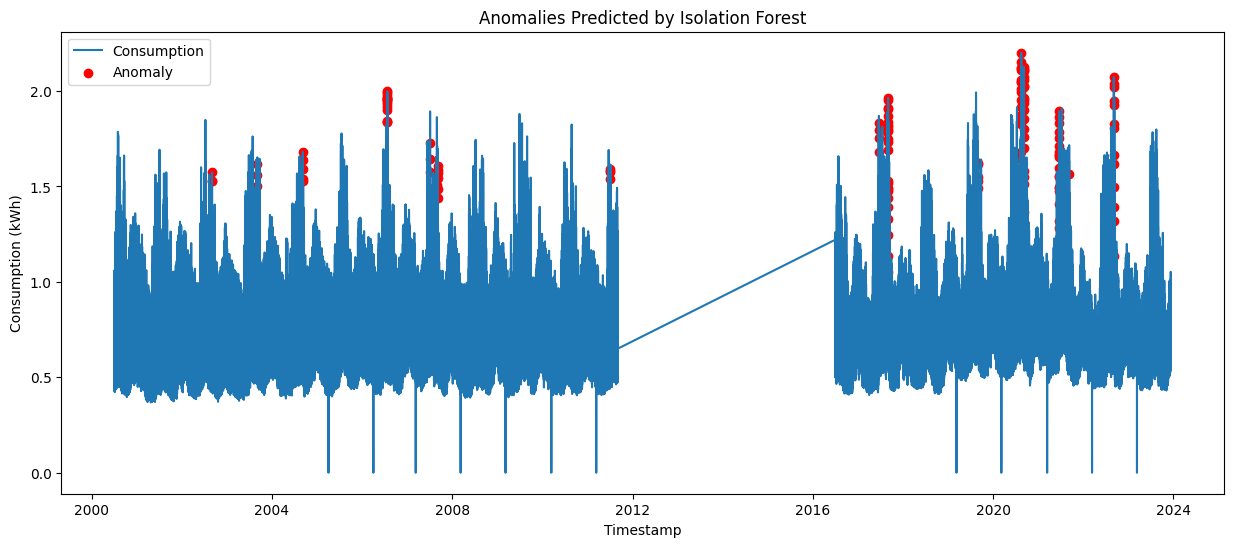

In [25]:
# Plot anomalies
plt.figure(figsize=(15, 6))
plt.plot(clean_df.index, clean_df['Consumption'], label='Consumption')
plt.scatter(prediction_df.index[prediction_df['Isolation Forest'] == 1], clean_df['Consumption'][prediction_df['Isolation Forest'] == 1], color='red', label='Anomaly')
plt.xlabel('Timestamp')
plt.ylabel('Consumption (kWh)')
plt.title('Anomalies Predicted by Isolation Forest')
plt.legend()
plt.show()

The isolation forest model recognizes particularly high spikes in the summer. It doesn't seem to recognize the drops I mentioned before as anomalies, however.

### One-class SVM
One-class support vector machine (SVM) is another method for anomaly detection that tries to find a hyperplane that separates the normal data from the anomalies. Similarly to how an SVM classifier finds a decision boundary to separate classes in the data, One-class SVM finds a decision boundary to separate normal data form anomalies.

In [26]:
from sklearn.svm import OneClassSVM

In [27]:
# The gamma parameter relates to the influence of each data point. 
# The higher the gamma value, the more localized the influence, and the more likely small deviations from the data are to be classified as anomalies.
# The nu parameter relates to the proportion of points in the data are expected to be anomalies.
oneclass = OneClassSVM(kernel='rbf', gamma=0.04, nu=0.001)
oneclass.fit(features)

# Predict anomalies
prediction_df['SVM'] = oneclass.predict(features)
prediction_df['SVM'] = prediction_df['SVM'].map({1: 0, -1: 1})


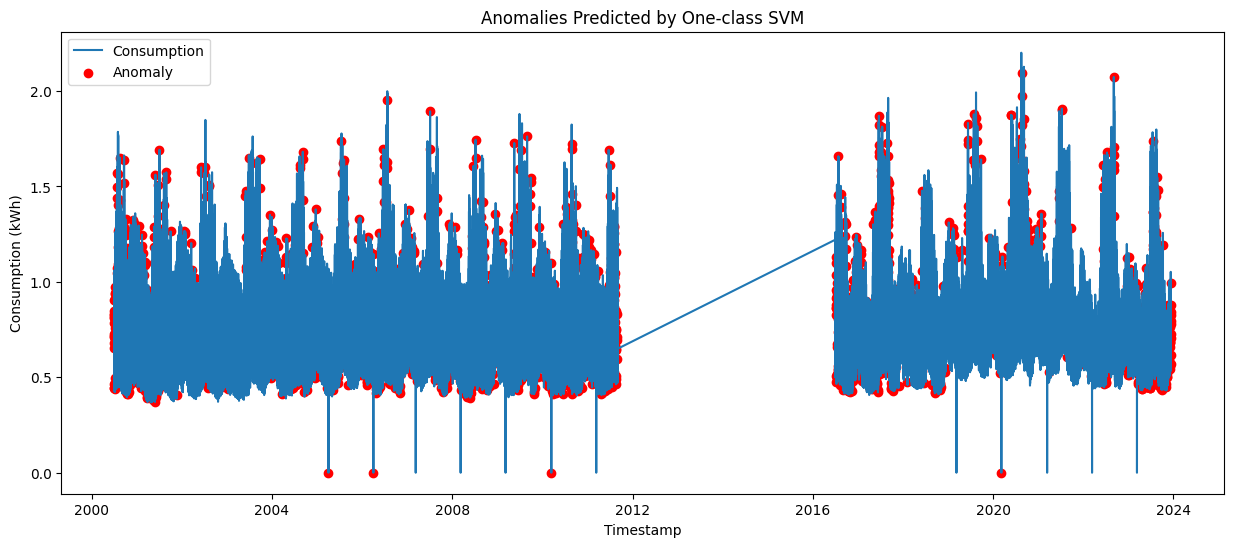

In [28]:
# Plot anomalies
plt.figure(figsize=(15, 6))
plt.plot(clean_df.index, clean_df['Consumption'], label='Consumption')
plt.scatter(prediction_df.index[prediction_df['SVM'] == 1], clean_df['Consumption'][prediction_df['SVM'] == 1], color='red', label='Anomaly')
plt.xlabel('Timestamp')
plt.ylabel('Consumption (kWh)')
plt.title('Anomalies Predicted by One-class SVM')
plt.legend()
plt.show()

The one-class SVM seems to have worse performance than the isolation forest. It classifies most high and low points as anomalies, seeming to not understand the seasonality of the data.

### Local Outlier Factor (LOF)
Local Outlier Factor identifies anomalies by the density deviation of data points from their nearest neighbors. Density is inversely related to the average distance between a point and its k nearest neighbors.

In [29]:
from sklearn.neighbors import LocalOutlierFactor

In [30]:
lof = LocalOutlierFactor(n_neighbors=72, contamination=0.001)
prediction_df['LOF'] = lof.fit_predict(features)
prediction_df['LOF'] = prediction_df['LOF'].map({1: 0, -1: 1})

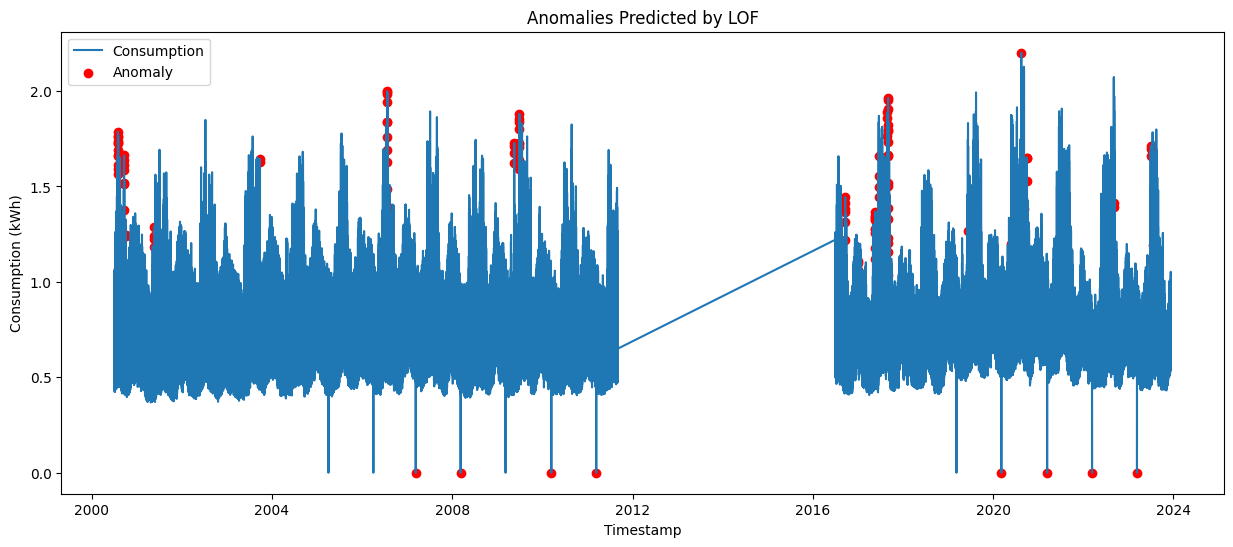

In [31]:
# Plot anomalies
plt.figure(figsize=(15, 6))
plt.plot(clean_df.index, clean_df['Consumption'], label='Consumption')
plt.scatter(prediction_df.index[prediction_df['LOF'] == 1], clean_df['Consumption'][prediction_df['LOF'] == 1], color='red', label='Anomaly')
plt.xlabel('Timestamp')
plt.ylabel('Consumption (kWh)')
plt.title('Anomalies Predicted by LOF')
plt.legend()
plt.show()

LOF seems to do better at identifying more of the sudden drops in energy consumption as anomalies.

### RNN
The RNN is a deep learning model that attempts to learn long-range dependencies in time series data. When using it for anomaly detection, I first train an RNN to predict the next data point from a previous sequence, and then classify any points far from the prediction as anomalies.

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [33]:
sequence_length = 24 * 7 # sequence length of one week

pre_features = clean_df[clean_df.index < '2012-03-02'].drop(columns=['Consumption', 'Normalized Consumption', 'Normalized Rolling Mean', 'Normalized Rolling Standard Deviation', 'Residual', 'Normalized Residual']).values
post_features = clean_df[clean_df.index > '2016-01-01'].drop(columns=['Consumption', 'Normalized Consumption', 'Normalized Rolling Mean', 'Normalized Rolling Standard Deviation', 'Residual', 'Normalized Residual']).values


In [35]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]  # Target only the standardized consumption value
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [51]:
pre_x, pre_y = create_sequences(pre_features, sequence_length)
post_x, post_y = create_sequences(post_features, sequence_length)

x = np.concatenate((pre_x, post_x), axis=0)
y = np.concatenate((pre_y, post_y), axis=0)

In [56]:
rnn = Sequential([
    LSTM(128, input_shape=(sequence_length, x.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Predict only the standardized consumption value
])

rnn.compile(optimizer='adam', loss='mse')
rnn.summary()

# Train the model
history = rnn.fit(x, y, epochs=5, batch_size=32, validation_split=0.1)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 168, 128)       │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 168, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 168, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 168, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,689 (604.25 KB)

 Trainable params: 154,689 (604.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
4579/4579 ━━━━━━━━━━━━━━━━━━━━ 716s 156ms/step - loss: 1.0095 - val_loss: 1.0050
Epoch 2/5
4579/4579 ━━━━━━━━━━━━━━━━━━━━ 703s 154ms/step - loss: 1.0283 - val_loss: 1.0115
Epoch 3/5
4579/4579 ━━━━━━━━━━━━━━━━━━━━ 712s 155ms/step - loss: 1.0267 - val_loss: 1.0053
Epoch 4/5
4579/4579 ━━━━━━━━━━━━━━━━━━━━ 724s 158ms/step - loss: 1.0208 - val_loss: 1.0142
Epoch 5/5
4579/4579 ━━━━━━━━━━━━━━━━━━━━ 1410s 308ms/step - loss: 1.0271 - val_loss: 1.0121


In [57]:
# Predict on test set
y_pred = rnn.predict(x)

# Calculate reconstruction error
reconstruction_error = np.abs(y_pred - y.reshape(-1, 1))

# Determine the threshold for anomalies
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)

# Identify anomalies
anomalies = reconstruction_error > threshold

5088/5088 ━━━━━━━━━━━━━━━━━━━━ 217s 43ms/step


(162804, 1)
(162804,)
(162804, 1)
(162804, 1)


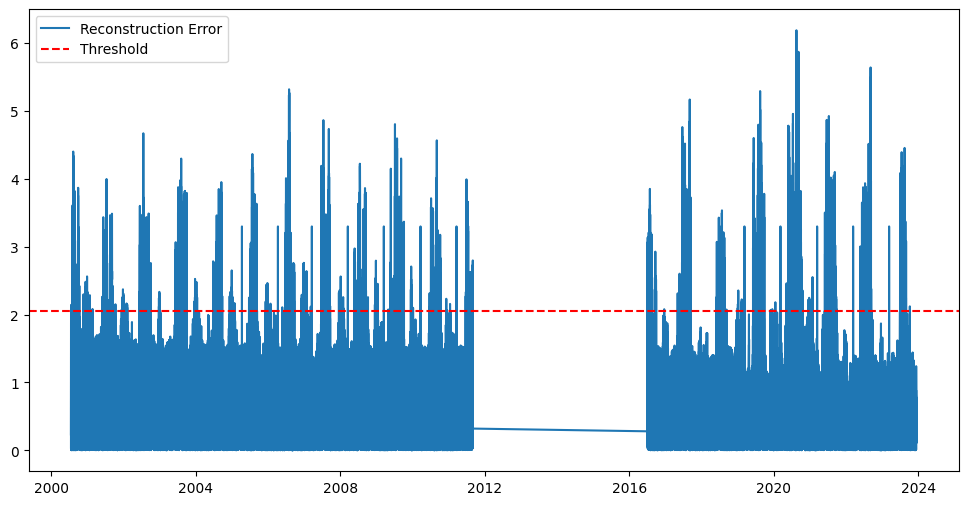

In [59]:
print(y_pred.shape)
print(y.shape)
print(reconstruction_error.shape)
print(anomalies.shape)
# Results
plt.figure(figsize=(12, 6))
plt.plot(clean_df.index[-len(y):], reconstruction_error, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

The RNN seems to perform similarly to the isolation forest and one-class SVM, classifying most seasonal spikes as anomalies. It could potentially perform better with more training/different features, but I am limited by computational power.